In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import transform_feature
from DataBaseControl import DataBaseControl
import model
from functools import reduce
from sklearn.preprocessing import MinMaxScaler

</b>기술적 지표 선택 기준</b>
* 피쳐는 기본적인 ohlcv와 더불어 대표적으로 사용되는 기술적 지표들은 OBV, RSI, MACD, Stochastic, William 지표를 활용했다.
* 피쳐 선택 또한 신중히 해야하나 금융 쪽 도메인에 대한 명확한 이해가 없어 각종 논문이나 서적에서 자주 참고하는 지표를 채택했다.
* https://github.com/areed1192/sigma_coding_youtube/blob/master/python/python-data-science/machine-learning/random-forest/random_forest_price_prediction.ipynb (해당 노트북으로 부터 많은 아이디어를 참고했다.)

In [79]:

db_control = DataBaseControl("raw","BTCUSD", "1d")
bit =  db_control.get_df("*")
bit = bit.loc[~bit.index.duplicated()]
bit.dropna(inplace=True)
bit.drop_duplicates(inplace=True)
transformer = transform_feature.FeatureTransformer(adj_close=bit['Adj Close'], high=bit['High'], low=bit['Low'], volume=bit['Volume'])
transformer.transform(bit, is_coin = True)
bit

Create new feature complete


,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William
Date,,,,,,,,,,,
2015-02-10,220.281998,221.807007,215.332001,219.839005,219.839005,21115100,42.597041,0.827181,-3.142676,-155617504,-67.587762
2015-02-11,219.731995,223.406006,218.074005,219.184998,219.184998,17201900,42.330900,0.823603,-7.993992,-172819404,-78.517210
2015-02-12,219.207993,222.199005,217.613998,221.764008,221.764008,15206200,43.821488,0.828948,-2.421809,-157613204,-76.272211
2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,51.041239,0.859644,3.779542,-114868804,-64.378730
2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,59.928230,0.908610,18.520491,-65136304,-49.949619
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,39698.371094,36754404490,48.365955,61.845985,-1.878322,1876222660908,-65.365841
2022-05-05,39695.746094,39789.281250,35856.515625,36575.140625,36575.140625,43106256317,38.143361,61.370995,-4.046230,1833116404591,-90.443643
2022-05-06,36573.183594,36624.359375,35482.132812,36040.921875,36040.921875,37795577489,36.713965,60.948847,-8.155219,1795320827102,-92.921565


<b>비트코인 데이터 이외</b>
* 비트코인 가격만으로 학습을 시킬 경우 외부 상황이나 경제적 이슈에 대응하지 못할 수 있기에 대표적인 경제 지표들은 학습 가능하게 추가해뒀다.
* 비트코인 가격이외 추가적으로 사용하는 피쳐는 나스닥 etf인 qqq, 미국 10년물 국채 금리, 금 선물 가격, 달러 인덱스, VIX 지수이다.


In [80]:
vix = db_control.get_df("Date","Close", table_name="VIX_1d")
usd = db_control.get_df("Date","Close", table_name="DXF_1d")
tnx = db_control.get_df("Date","Close", table_name="TNX_1d")
gld = db_control.get_df("Date","Close", table_name="GCF_1d")
qqq = db_control.get_df("Date","Close", table_name="QQQ_1d")
ovx = db_control.get_df("Date","Close", table_name="OVX_1d")

data_frames = [bit, vix, usd, tnx, qqq, gld, ovx]
for df, ticker in zip(data_frames[1:], ["VIX","USD","TNX" ,"QQQ", "GOLD","OVX"]):
    df.columns = [f"{ticker}_{c}" for c in df.columns]


In [81]:
df = reduce(lambda left, right: left.join(right), data_frames)
df

,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close,OVX_Close
Date,,,,,,,,,,,,,,,,,
2015-02-10,220.281998,221.807007,215.332001,219.839005,219.839005,21115100,42.597041,0.827181,-3.142676,-155617504,-67.587762,NaN,NaN,NaN,104.400002,NaN,NaN
2015-02-11,219.731995,223.406006,218.074005,219.184998,219.184998,17201900,42.330900,0.823603,-7.993992,-172819404,-78.517210,NaN,NaN,NaN,104.779999,NaN,NaN
2015-02-12,219.207993,222.199005,217.613998,221.764008,221.764008,15206200,43.821488,0.828948,-2.421809,-157613204,-76.272211,NaN,NaN,NaN,106.000000,NaN,NaN
2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,51.041239,0.859644,3.779542,-114868804,-64.378730,NaN,NaN,NaN,106.910004,NaN,NaN
2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,59.928230,0.908610,18.520491,-65136304,-49.949619,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,39698.371094,36754404490,48.365955,61.845985,-1.878322,1876222660908,-65.365841,25.420000,102.594002,2.917,329.600006,1867.000000,53.150002
2022-05-05,39695.746094,39789.281250,35856.515625,36575.140625,36575.140625,43106256317,38.143361,61.370995,-4.046230,1833116404591,-90.443643,31.200001,103.802002,3.066,313.000000,1874.000000,54.720001
2022-05-06,36573.183594,36624.359375,35482.132812,36040.921875,36040.921875,37795577489,36.713965,60.948847,-8.155219,1795320827102,-92.921565,30.190001,103.680000,3.123,309.250000,1881.199951,54.820000


In [82]:
new_df = df.loc[~df.index.duplicated()]
new_df = new_df.ffill()
new_df['Target'] = np.sign(new_df['Adj Close'].diff()).shift(-1)
new_df.dropna(inplace=True)
new_df

,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close,OVX_Close,Target
Date,,,,,,,,,,,,,,,,,,
2015-02-27,236.436005,256.653015,236.436005,253.828003,253.828003,44013900,58.602115,0.924069,7.405871,-91677804,-21.984833,13.340000,95.320999,2.002,108.400002,1212.599976,55.849998,1.0
2015-02-28,253.520004,254.692001,249.479004,254.263000,254.263000,13949300,58.802083,0.921736,5.818138,-77728504,-22.300819,13.340000,95.320999,2.002,108.400002,1212.599976,55.849998,1.0
2015-03-01,254.283005,261.660004,245.932999,260.201996,260.201996,25213700,61.534015,0.934267,6.736835,-52514804,-10.629639,13.340000,95.320999,2.002,108.400002,1212.599976,55.849998,1.0
2015-03-02,260.356995,276.300995,258.312988,275.670013,275.670013,40465700,67.566482,0.968223,12.732797,-12049104,-1.024720,13.040000,95.478996,2.084,109.379997,1207.699951,54.919998,1.0
2015-03-03,275.045990,285.795990,268.161011,281.701996,281.701996,50461300,69.570593,0.980679,19.376884,38412196,-5.760430,13.860000,95.407997,2.122,108.870003,1204.000000,53.049999,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,38528.109375,38629.996094,37585.621094,37750.453125,37750.453125,27326943244,38.879318,61.988710,-4.354879,1839468256418,-97.928917,29.250000,103.496002,2.960,318.820007,1868.800049,54.040001,1.0
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,39698.371094,36754404490,48.365955,61.845985,-1.878322,1876222660908,-65.365841,25.420000,102.594002,2.917,329.600006,1867.000000,53.150002,-1.0
2022-05-05,39695.746094,39789.281250,35856.515625,36575.140625,36575.140625,43106256317,38.143361,61.370995,-4.046230,1833116404591,-90.443643,31.200001,103.802002,3.066,313.000000,1874.000000,54.720001,-1.0


<b>최종 데이터 설명</b>
* 모델 학습을 위한 데이터는 2015.02.10~2022.05.07까지 약 7년 간 1일 간격의 데이터이다.
* 주식이나 금리 데이터 등의 경우 주말 데이터가 존재하지 않아 데이터의 수가 더 적어야 하지만,
부족한 데이터 수를 매워보고자 금요일의 데이터를 복사해 넣는 방식으로 데이터를 구성했다.
* 결측치나 중복이 발생한 데이터를 제외하고 총 데이터는 2626개로 구성된다.

<b>모델 설명</b>
* 모델은 랜덤 포레스트 분류기를 사용할 것이며 모델이 예측하는 값은 내일 비트코인이 상승인지 하락인지이다.
* 랜덤 포레스트를 사용한 까닭과 회귀를 통한 가격 예측이 아닌 분류를 사용한 이유는 정확도 때문이다.
* 모델의 학습 방식은 다음과 같다.
    * 모델은 120일 단위로 학습을 진행한다. 
    * 모델의 학습은 매일 이뤄지며 오늘까지의 총 120일간의 데이터로 다음날 방향성을 예측한다.

In [83]:
X = new_df.drop(['Target'],axis=1)
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [84]:
SIZE = 120
feature_res = pd.DataFrame(columns= X.columns)
pred = []
f1_res = pd.DataFrame()
total_pred = []
for i in range(len(new_df) - SIZE - 1):
    train_X = X.iloc[i: i + SIZE]
    train_y = new_df['Target'].iloc[i: i + SIZE]

    test_X = X.iloc[i + SIZE]
    test_y = new_df['Target'].iloc[i + SIZE]

    rf_model = RandomForestClassifier(n_jobs=-1)
    rf_model.fit(train_X, train_y)
    pred_value = rf_model.predict([test_X])[0]
    pred.append(pred_value)
    total_pred.append(pred_value)

    if len(pred) == SIZE:
        target = new_df['Target'].iloc[i : i + SIZE]
        feature_imp = pd.DataFrame(data=rf_model.feature_importances_).T
        feature_imp.columns=train_X.columns
        feature_res = pd.concat([feature_res, feature_imp])

        cls_report = classification_report(target, pred, output_dict=True, target_names=["up", "down"], labels=[1,-1])
        up_report = pd.DataFrame([cls_report["up"]])
        down_report = pd.DataFrame([cls_report["down"]])

        up_report.columns = ["up_" + c for c in up_report]
        down_report.columns = ["down_" + c for c in down_report]

        cls_report = pd.concat([up_report, down_report], axis=1)
        f1_res = f1_res.append(cls_report)
        
        pred = []
        


In [85]:
f1_res.describe()

,up_precision,up_recall,up_f1-score,up_support,down_precision,down_recall,down_f1-score,down_support
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.654110,0.641879,0.643947,65.650000,0.571436,0.581475,0.571962,54.300000
std,0.070996,0.065935,0.046945,7.499298,0.069772,0.104702,0.071355,7.595705
min,0.513158,0.516129,0.576577,56.000000,0.431373,0.403226,0.452381,40.000000
25%,0.590721,0.605680,0.616463,60.000000,0.528911,0.523438,0.513621,50.500000
50%,0.683333,0.644581,0.640295,64.000000,0.591667,0.553846,0.581366,56.000000
75%,0.716042,0.691292,0.664682,69.500000,0.618939,0.649747,0.617048,60.000000
max,0.753425,0.779412,0.736111,79.000000,0.666667,0.771930,0.691729,64.000000


In [111]:
f1_res.reset_index(drop=True, inplace=True)

In [112]:
f1_res[f1_res['up_f1-score'] == f1_res['up_f1-score'].max()]

,up_precision,up_recall,up_f1-score,up_support,down_precision,down_recall,down_f1-score,down_support
7,0.697368,0.779412,0.736111,68,0.659091,0.557692,0.604167,52


In [86]:
feature_res.describe()

,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close,OVX_Close
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.059801,0.056038,0.054184,0.057892,0.059953,0.073776,0.063943,0.058704,0.064655,0.077839,0.065131,0.050907,0.057629,0.048144,0.048744,0.051797,0.050863
std,0.010332,0.008439,0.008932,0.010500,0.014977,0.012526,0.010039,0.011082,0.012263,0.017766,0.011747,0.010198,0.016388,0.008357,0.010917,0.017641,0.008344
min,0.046694,0.040973,0.035184,0.045601,0.045664,0.053014,0.035762,0.041427,0.046724,0.053052,0.049673,0.036288,0.033665,0.031551,0.029898,0.033789,0.036674
25%,0.052129,0.050125,0.048972,0.051259,0.050604,0.067339,0.057529,0.051573,0.056593,0.059450,0.055125,0.043759,0.044572,0.042500,0.040189,0.040759,0.046378
50%,0.056496,0.055630,0.053594,0.054841,0.055056,0.069791,0.067357,0.058377,0.062158,0.079772,0.063781,0.049015,0.054814,0.049469,0.047670,0.047939,0.049866
75%,0.065975,0.063142,0.062222,0.064237,0.062620,0.079990,0.070547,0.064007,0.070141,0.088890,0.073945,0.055586,0.066164,0.053445,0.056795,0.055098,0.057522
max,0.084688,0.071770,0.066681,0.088225,0.108811,0.106610,0.077220,0.087428,0.099358,0.113005,0.093014,0.072249,0.094483,0.060419,0.066097,0.116053,0.069027


Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

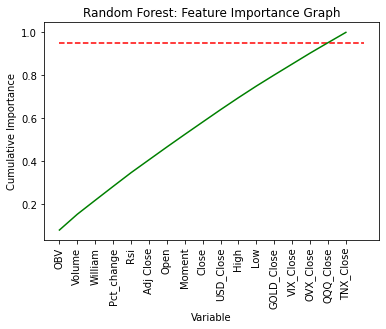

In [87]:
# Cumulative importances
cumulative_importances = feature_res.mean().sort_values(ascending=False).cumsum()

# Make a line graph

plt.plot(cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(cumulative_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

<b>결과 설명</b>
* 모델의 정확도 자체는 준수한 편이다. 평균적인 f1_score는 0.6정도이다.
* 피쳐는 볼륨(거래량)과 연관된 지표에 크게 영향을 받는다.
* 비트코인이 아닌 지표들 중에는 미국 달러와 금이 영향을 크게 미치는 요소이다.


In [88]:
date_index = new_df.index[SIZE: len(total_pred) + SIZE]
pred_series = pd.Series(index=date_index, data=total_pred)
target = new_df['Target'].loc[date_index]

In [89]:
pred_series.to_csv("pred.csv")
new_df.to_csv("new_df.csv")

In [136]:
def get_trade_point(pred): 
    long_point = [] 
    short_point = [] 
    before = 1
    for date, value in pred.items():
        # if value * before < 0:
        if value > 0:
            long_point.append(date)
        else:
            short_point.append(date)
        # before = value
    
    return long_point, short_point

def get_profit(in_point, is_short=False):
    """ 예측 데이터와 실제 가격의 증감률의 차이에 따라 투자 조건을 다르게 했을 때의
    달라지는 수익률 곡선을 구해준다.
    """
    out_point = [new_df.index.get_loc(p) + 1 for p in in_point]
    if out_point[-1] >= len(new_df):
        out_point = out_point[:-1]
        in_point = in_point[:-1]
    if is_short:
        profit = (new_df['Adj Close'].loc[in_point].values - new_df['Adj Close'].iloc[out_point].values).cumsum()
    else:
        profit = (new_df['Adj Close'].iloc[out_point].values - new_df['Adj Close'].loc[in_point].values).cumsum()
    return profit

# target_long_point, target_short_point = get_trade_point(target)



In [116]:
def plot_point(long_point, short_point, days=300):
    out_value = new_df['Adj Close'].loc[short_point]
    in_value = new_df['Adj Close'].loc[long_point]
    plt.figure(figsize=(16,10))
    plt.plot(df['Adj Close'])
    plt.scatter(x=short_point, y = out_value, c='b')
    plt.scatter(x=long_point, y = in_value, c='r')
    # plt.xlim(new_df.index[-days], new_df.index[-SIZE])


(20000.0, 65000.0)

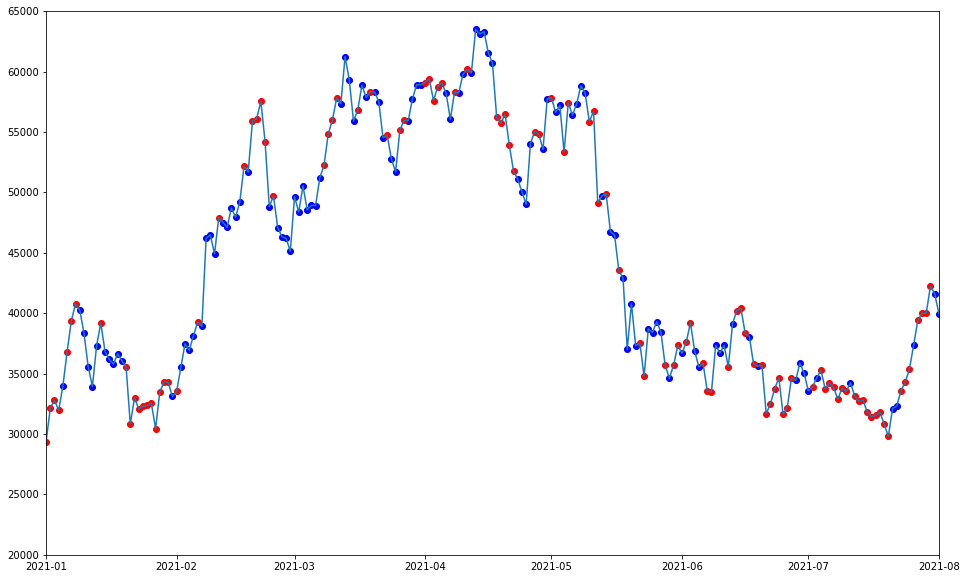

In [143]:
start_day, end_day = ("2021-01-01","2021-08-01")
long_point, short_point = get_trade_point(pred_series[start_day: end_day])
plot_point(long_point, short_point)
plt.xlim(start_day, end_day)
plt.ylim(20000, 65000)


In [147]:
new_df.Pct_change

Date
2015-02-27     7.405871
2015-02-28     5.818138
2015-03-01     6.736835
2015-03-02    12.732797
2015-03-03    19.376884
                ...    
2022-05-03    -4.354879
2022-05-04    -1.878322
2022-05-05    -4.046230
2022-05-06    -8.155219
2022-05-07   -10.740417
Name: Pct_change, Length: 2626, dtype: float64

<AxesSubplot:xlabel='Date'>

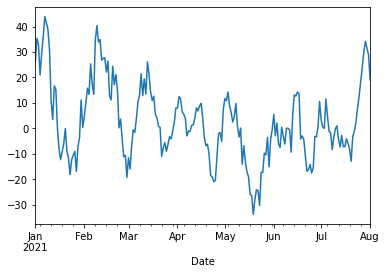

In [148]:
new_df.loc[start_day:end_day,'Pct_change'].plot()

<b>단순한 매매로직</b>
* 단순하게 모델이 상승을 예측한 날에 매수를 하고 다음날 바로 매도하는 로직으로 매매를 진행해보자.
* 수익률은 일정 구간동안 괜찮은 모습을 보이다. 특정 기간에 크게 하락하는 모습을 보인다.
* 하락장에서 잘 대응하지 못하는 듯 보인다.

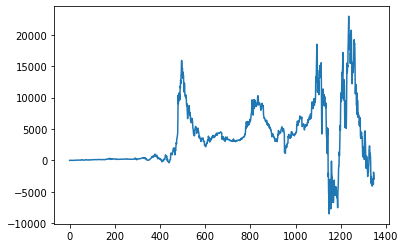

In [94]:
plt.plot(get_profit(long_point))

<AxesSubplot:xlabel='Date'>

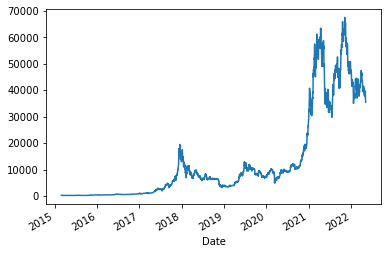

In [138]:
new_df['Adj Close'].plot()

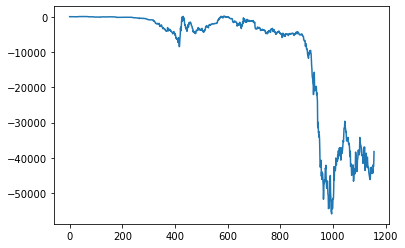

In [95]:
plt.plot(get_profit(short_point, is_short=True))

모델 예측 값과 MACD 아이디어의 조합
* 모델 예측 값을 하루 단위로 사용하면 문제가 많다.
* 모델 예측 값을 이동평균으로 변환해 평균적인 수치를 활용해보자.
* MACD의 아이디어를 모델 예측 값에 그대로 적용했다. 
    * 다만 주식보다 변환이 극심하다는 점을 고려해 MACD의 주기를 절반으로 설정했다.


In [96]:
exp_short = pred_series.ewm(span = 6, adjust=False).mean()
exp_long = pred_series.ewm(span = 13, adjust=False).mean()
ewm = new_df['Adj Close'].ewm(span=100, adjust=False).mean()
macd = exp_short - exp_long
signal = macd.ewm(span=5, adjust=False).mean()
osi = macd - signal



(array(18628.), array(18840.))

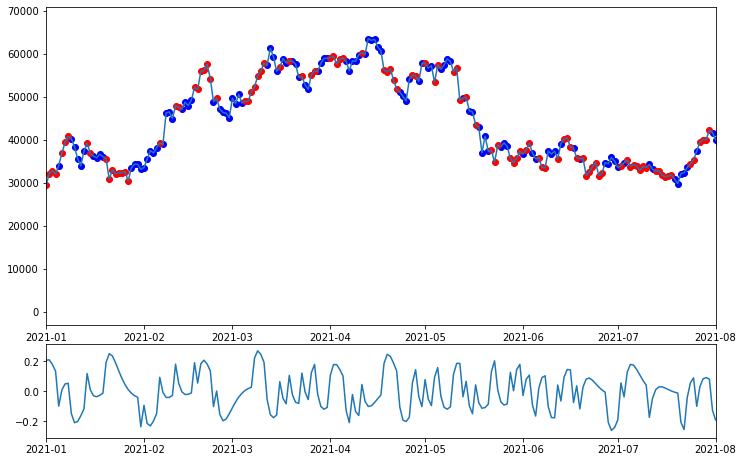

In [160]:
long_point = osi[osi > 0].index
short_point = osi[osi < 0].index
out_value = new_df['Adj Close'].loc[short_point]
in_value = new_df['Adj Close'].loc[long_point]
# plot_point(long_point, short_point)
# plt.xlim(start_day, end_day)
fig = plt.figure(figsize=(12,10))

ax_main = plt.subplot2grid((5, 1), (0, 0), rowspan=3)
ax_sub = plt.subplot2grid((5, 1), (3, 0))
# ax_sub2 = plt.subplot2grid((5, 1), (4, 0))

# start, end = (-300, len(new_df) - 1)
ax_main.plot(df['Adj Close'])
ax_main.scatter(x=short_point, y = out_value, c='b')
ax_main.scatter(x=long_point, y = in_value, c='r')
ax_main.set_xlim(start_day, end_day)
# ax_main.set_ylim(0, 15000)
# ax_main.plot(ewm)

ax_sub.plot(osi)
ax_sub.set_xlim(start_day, end_day)

# ax_sub2.plot(new_df['Moment'])
# ax_sub2.set_xlim(new_df.index[-400], new_df.index[-SIZE])



# plot_point(long_point, short_point)

In [98]:
macd_df = df.loc[ewm.index.intersection(osi.index)]

macd 전략을 시도했을 때 수익률을 구해보자.
* stop loss = -3%. profit border = 5%
* 손절라인이나 익절라인에 미치지 않으면 매도를 하지 않는다.
* 익절라인에서 시그널이 재 발생하면 홀드를 하고 손,익절 경계를 다시 설정한다.

In [99]:
profit = {}
up, bottom = (0,0)
entry_price = 0
prices = macd_df['Adj Close']
sell_pct = lambda x: (x - entry_price) / entry_price
in_day = []
out_day = []
high = 0
for day, p in prices.items():
    if entry_price:
        if bottom >= p:
            profit[day] = (sell_pct(p))
            out_day.append(day)
            entry_price = 0
        elif p >= up:
            if p > ewm[day] and osi[day] > 0:
                in_day.append(day)
                up, bottom = p * 1.02, p
            else: 
                profit[day] = (sell_pct(p))
                out_day.append(day)
                entry_price = 0
    else:
        if p > ewm[day] and osi[day] > 0:
            in_day.append(day)
            up, bottom = p * 1.05, p * 0.97
            entry_price = p

모델의 예측 값과 MACD 전략을 복수로 활용해 사용할 경우 수익률 그래프는 다음과 같다.

<AxesSubplot:>

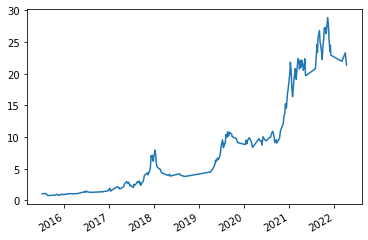

In [100]:
profit = pd.Series(profit) + 1
res = profit.cumprod()
res.plot()

In [101]:
p_std = res.std()
sharpe = (res[-1] - 0.21) / p_std
sharpe

2.6432686594028505

(array(18628.), array(18840.))

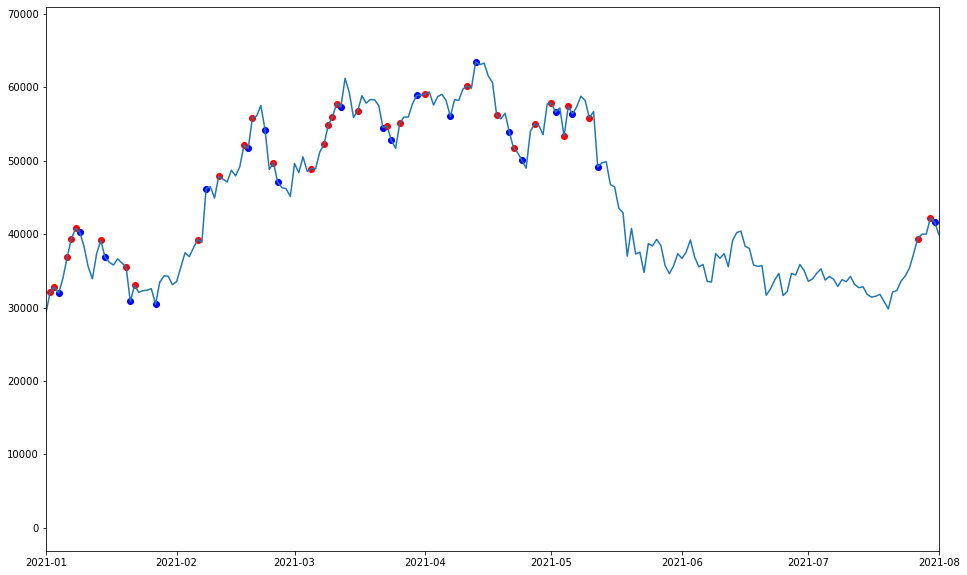

In [161]:
plot_point(in_day, out_day)
plt.xlim(start_day, end_day)
